In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize images to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add noise to the images
def add_noise(images, noise_factor=0.3):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy_images, 0., 1.)

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

# Reshape images to include channel dimension
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_train_noisy = np.expand_dims(x_train_noisy, axis=-1)
x_test_noisy = np.expand_dims(x_test_noisy, axis=-1)

print(f"x_train shape: {x_train.shape}")
print(f"x_train_noisy shape: {x_train_noisy.shape}")

2024-09-04 14:59:14.625800: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-04 14:59:14.661088: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-04 14:59:14.855531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 14:59:14.855626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 14:59:14.887017: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

x_train shape: (60000, 28, 28, 1)
x_train_noisy shape: (60000, 28, 28, 1)


In [2]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

def build_autoencoder():
    input_img = Input(shape=(28, 28, 1))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

autoencoder = build_autoencoder()
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928 

In [3]:
# Train the autoencoder
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    validation_data=(x_test_noisy, x_test)
)


Epoch 1/50
469/469 [==============================] - 11s 22ms/step - loss: 0.1333 - val_loss: 0.0888
Epoch 2/50
469/469 [==============================] - 10s 21ms/step - loss: 0.0867 - val_loss: 0.0837
Epoch 3/50
469/469 [==============================] - 10s 20ms/step - loss: 0.0835 - val_loss: 0.0822
Epoch 4/50
469/469 [==============================] - 10s 21ms/step - loss: 0.0818 - val_loss: 0.0810
Epoch 5/50
469/469 [==============================] - 10s 21ms/step - loss: 0.0807 - val_loss: 0.0796
Epoch 6/50
469/469 [==============================] - 10s 21ms/step - loss: 0.0798 - val_loss: 0.0790
Epoch 7/50
469/469 [==============================] - 9s 19ms/step - loss: 0.0792 - val_loss: 0.0785
Epoch 8/50
469/469 [==============================] - 10s 21ms/step - loss: 0.0788 - val_loss: 0.0781
Epoch 9/50
469/469 [==============================] - 10s 21ms/step - loss: 0.0784 - val_loss: 0.0777
Epoch 10/50
469/469 [==============================] - 10s 22ms/step - loss: 0.0780

313/313 [==============================] - 1s 2ms/step


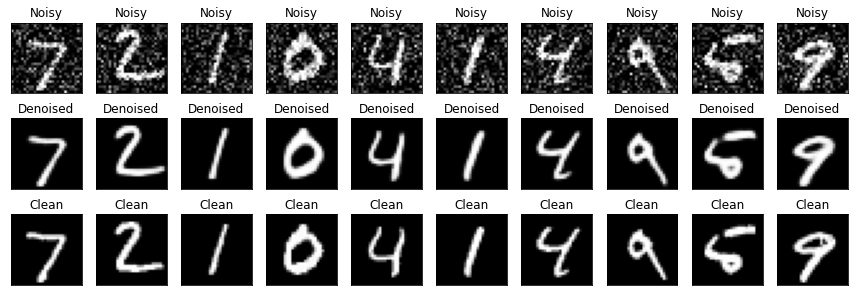

In [4]:
# Predict on test data
denoised_images = autoencoder.predict(x_test_noisy)

# Display some noisy and denoised images
def display_results(noisy, denoised, clean):
    plt.figure(figsize=(15, 5))
    for i in range(10):
        # Display noisy image
        ax = plt.subplot(3, 10, i + 1)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # Display denoised image
        ax = plt.subplot(3, 10, i + 11)
        plt.imshow(denoised[i].reshape(28, 28), cmap='gray')
        plt.title("Denoised")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # Display clean image
        ax = plt.subplot(3, 10, i + 21)
        plt.imshow(clean[i].reshape(28, 28), cmap='gray')
        plt.title("Clean")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

display_results(x_test_noisy, denoised_images, x_test)